In [1]:
import tensorflow as tf

In [2]:
import deepchem as dc
import rdkit as rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import pandas as pd

In [3]:
import numpy as np

In [4]:
print('tf version:', tf.__version__, '\nGPU avilable?:', tf.config.list_physical_devices('GPU'))
print('rdkit version: ', rdkit.__version__)
print('DeepChem version', dc.__version__)

tf version: 2.3.0 
GPU avilable?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
rdkit version:  2020.09.1
DeepChem version 2.4.0-rc1.dev


In [5]:
from feat.simple_mol_graph_conv_featurizer import SimpleMolGraphConvFeaturizer
from layers.layers import GraphEncoderLayer
from tensorflow.keras import layers

In [6]:
data = pd.read_csv('./data/QM9_HAC_5_9_.csv')

In [7]:
reduced_data = list(data['SMILES'])
import random
random.shuffle(reduced_data)

In [8]:
mols = list(filter(lambda x: x is not None, [Chem.MolFromSmiles(x) for x in reduced_data]))
print('how many molecules obtained from smiles: ', len(mols))

how many molecules obtained from smiles:  132432


In [9]:
from deepchem.feat.graph_data import GraphData
from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol

class GraphMatrix():
    """
    Parameters
    ----------
    node_features: np.ndarray
      Node feature matrix with shape [num_nodes, num_node_features]
    edge_features: np.ndarray,
      Edge feature matrix with shape [num_nodes, num_nodes]
    """
    
    bond_labels = [
        Chem.rdchem.BondType.ZERO
        ,Chem.rdchem.BondType.SINGLE
        ,Chem.rdchem.BondType.DOUBLE
        ,Chem.rdchem.BondType.TRIPLE
        ,Chem.rdchem.BondType.AROMATIC]
    bond_encoder = {l: i for i, l in enumerate(bond_labels)}
    bond_decoder = {i: l for i, l in enumerate(bond_labels)}

    atom_labels = [0, 6, 7, 8, 9] #C,N,O,F
    atom_encoder = {l: i for i, l in enumerate(atom_labels)}
    atom_decoder = {i: l for i, l in enumerate(atom_labels)}
    
    
    def __init__(self,adjacency_matrix: np.ndarray, node_features: np.ndarray):
        self.adjacency_matrix = adjacency_matrix
        self.node_features = node_features

def SimpleGraphMatrixFeaturizer(mol: RDKitMol, length: int = 9) -> GraphMatrix:
        Chem.Kekulize(mol)
        A = np.zeros(shape=(length, length), dtype=np.float32)
        bonds = mol.GetBonds()

        begin, end = [b.GetBeginAtomIdx() for b in bonds], [b.GetEndAtomIdx() for b in bonds]
        bond_type = [GraphMatrix.bond_encoder[b.GetBondType()] for b in bonds]

        A[begin, end] = bond_type
        A[end, begin] = bond_type

        degree = np.sum(A[:mol.GetNumAtoms(), :mol.GetNumAtoms()], axis=-1)
        #A = tf.one_hot(A,depth=5, dtype=tf.float32)
        #proto_tensor = tf.make_tensor_proto(A)
        #A = tf.make_ndarray(proto_tensor)

        X = np.array([GraphMatrix.atom_encoder[atom.GetAtomicNum()] for atom in mol.GetAtoms()] + [0] * (length - mol.GetNumAtoms()), dtype=np.int32)
        #X = tf.one_hot(X, depth = 9, dtype=tf.float32)
        #proto_tensor = tf.make_tensor_proto(X)
        #X = tf.make_ndarray(proto_tensor)
        
        gm = GraphMatrix(A,X)
           
        return gm if (degree > 0).all() else None
    
def SimpleGraphMatrixDefeaturizer(graph_matrix: GraphMatrix, sanitize=True) -> RDKitMol:
    node_labels = graph_matrix.node_features
    edge_labels = graph_matrix.adjacency_matrix
   
    mol = Chem.RWMol()
    
    for node_label in node_labels:
        mol.AddAtom(Chem.Atom(GraphMatrix.atom_decoder[node_label]))

    for start, end in zip(*np.nonzero(edge_labels)):
        if start > end:
            mol.AddBond(int(start), int(end), GraphMatrix.bond_decoder[edge_labels[start, end]])

    if sanitize:
        try:
            Chem.SanitizeMol(mol)
        except:
            mol = None

    return mol

In [10]:
from tensorflow import keras
from deepchem.models.optimizers import ExponentialDecay
class MolGAN(dc.models.WGAN):
    
    def __init__(self
                 ,edges: int = 5
                 ,vertices:int = 9
                 ,nodes: int = 5
                 ,embedding_dim: int = 10
                 ,dropout_rate: float = 0.
                 ,name:str =''
                 , **kwargs):

        self.edges = edges
        self.vertices = vertices
        self.nodes =nodes
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate
        
        super(MolGAN, self).__init__(name=name, **kwargs)

    def get_noise_input_shape(self):
        return (self.embedding_dim,)

    def get_data_input_shapes(self):
        return [(self.vertices, self.vertices, self.edges),(self.vertices, self.nodes)]

    def create_generator(self):
        input_layer = layers.Input(shape=(self.embedding_dim,))
        x = layers.Dense(128, activation='tanh')(input_layer)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(256, activation='tanh')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(512, activation='tanh')(x)
        x = layers.Dropout(self.dropout_rate)(x)

        #EDGES LOGITS
        edges_logits = layers.Dense(units=self.edges*self.vertices*self.vertices, activation=None)(x)
        edges_logits = layers.Reshape((self.edges, self.vertices, self.vertices))(edges_logits)
        matrix_transpose = layers.Permute((1,3,2))(edges_logits)
        edges_logits = (edges_logits + matrix_transpose)/2
        edges_logits = layers.Permute((2,3,1))(edges_logits)
        edges_logits = layers.Dropout(self.dropout_rate)(edges_logits)
        
        #used during training of the model
        edges_softmax = tf.nn.softmax(edges_logits)
        
        #used for compound generation
        e_gumbel_logits = edges_logits - tf.math.log(- tf.math.log(tf.random.uniform(tf.shape(edges_logits), dtype=edges_logits.dtype)))
        e_gumbel_argmax = tf.one_hot(tf.argmax(e_gumbel_logits, axis=-1), depth=e_gumbel_logits.shape[-1], dtype=e_gumbel_logits.dtype) 
        e_argmax = tf.argmax(e_gumbel_argmax, axis=-1)
        

        #NODES LOGITS
        nodes_logits = layers.Dense(units=(self.vertices * self.nodes), activation=None)(x)
        nodes_logits = layers.Reshape((self.vertices, self.nodes))(nodes_logits)
        nodes_logits = layers.Dropout(self.dropout_rate)(nodes_logits)
        
        #used during training of the model
        nodes_softmax = tf.nn.softmax(nodes_logits)
        
        #used for compound generation
        n_gumbel_logits = nodes_logits - tf.math.log(- tf.math.log(tf.random.uniform(tf.shape(nodes_logits), dtype=nodes_logits.dtype)))
        n_gumbel_argmax = tf.one_hot(tf.argmax(n_gumbel_logits, axis=-1), depth=n_gumbel_logits.shape[-1], dtype=n_gumbel_logits.dtype)
        n_argmax = tf.argmax(n_gumbel_argmax, axis=-1)
        
        #final model
        return keras.Model(inputs = input_layer, outputs=[edges_softmax, nodes_softmax,e_argmax, n_argmax])
    
    def create_discriminator(self):
        adjacency_tensor= layers.Input(shape=(self.vertices, self.vertices, self.edges))
        node_tensor = layers.Input(shape=(self.vertices, self.nodes))
        
        graph = GraphEncoderLayer(units = [(128,64),128], dropout_rate= self.dropout_rate, edges=self.edges)([adjacency_tensor,node_tensor])
        dense = layers.Dense(units=128, activation='tanh')(graph)
        dense = layers.Dropout(self.dropout_rate)(dense)
        dense = layers.Dense(units=64, activation='tanh')(dense)
        dense = layers.Dropout(self.dropout_rate)(dense)
        output = layers.Dense(units=1)(dense)
               
        return keras.Model(inputs=[adjacency_tensor,node_tensor], outputs=[output])
    
    def predict_gan_generator(self,
                            batch_size=1,
                            noise_input=None,
                            generator_index=0):
        """Use the GAN to generate a batch of samples.
        Parameters
        ----------
        batch_size: int
          the number of samples to generate.  If either noise_input or
          conditional_inputs is specified, this argument is ignored since the batch
          size is then determined by the size of that argument.
        noise_input: array
          the value to use for the generator's noise input.  If None (the default),
          get_noise_batch() is called to generate a random input, so each call will
          produce a new set of samples.
        generator_index: int
          the index of the generator (between 0 and n_generators-1) to use for
          generating the samples.
        Returns
        -------
        An array (if the generator has only one output) or list of arrays (if it has
        multiple outputs) containing the generated samples.
        """
        if noise_input is not None:
            batch_size = len(noise_input)
        if noise_input is None:
            noise_input = self.get_noise_batch(batch_size)
        inputs = noise_input
        _,_,adjacency_matrix, nodes_features = gan.generators[0](inputs, training=False)
        graphs = [GraphMatrix(i,j) for i,j in zip(adjacency_matrix.numpy(),nodes_features.numpy())] 
        return graphs

gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

In [11]:
def generate(gan: MolGAN, samples:int = 10):
    _,_,adjacency_matrix, nodes_features = gan.generators[0](gan.get_noise_batch(samples), training=False)
    graphs = [GraphMatrix(i,j) for i,j in zip(adjacency_matrix.numpy(),nodes_features.numpy())] 
    return graphs

In [12]:
limited = list(filter(lambda x: x is not None,[SimpleGraphMatrixFeaturizer(x) for x in mols]))
print('compounds successfully turned from Graph', len(limited))

compounds successfully turned from Graph 132359


In [13]:
#create dataset
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in limited],[x.node_features for x in limited])

In [14]:
#prepare data for training
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = tf.one_hot(batch[0], gan.edges)
            node_tesor = tf.one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tesor}

In [15]:
#train model
gan.fit_gan(iterbatches(10), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 4999: generator average loss -15.7217, discriminator average loss -32.6912
Ending global_step 9999: generator average loss 134.3, discriminator average loss -290.426
Ending global_step 13239: generator average loss 290.151, discriminator average loss -513.284
TIMING: model fitting took 205.274 s


In [37]:
g = gan.predict_gan_generator(1000)

In [38]:
#g = generate(gan,1000)

In [39]:
#output clean-up methods
def convert(g):
    mols = [SimpleGraphMatrixDefeaturizer(x) for x in g]
    return mols
def strip (mols):
    mols = [Chem.MolFromSmiles(max(smiles.split('.'), key=len)) for smiles in [Chem.MolToSmiles(mol) for mol in mols]]
    return mols

In [40]:
#clean-up output
new_mols = convert(g)
new_mols = list(filter(lambda x: x is not None, new_mols))
new_mols = strip(new_mols)
print('how many valid molecules: ', len(new_mols))

how many valid molecules:  1000


In [41]:
newMoles = [Chem.MolFromSmiles(x) for x in list(filter(lambda x: '*' not in x, list(set([Chem.MolToSmiles(z) for z in new_mols]))))]

In [42]:
#how many unique molecules
print('how manu unique molecules: ', len(newMoles))

how manu unique molecules:  2


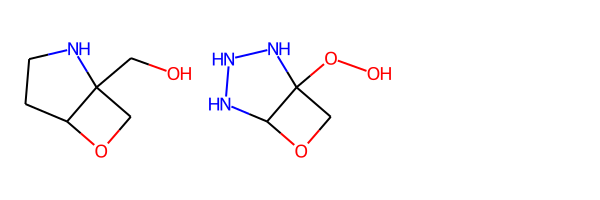

In [43]:
Chem.Draw.MolsToGridImage(newMoles)